# Support vector machines

Here we implement a support vector machine. We first derive the Lagrangian dual of the loss function and then optimize it using a numerical optimizer from `CVXPY`. In the end we benchmark our SVM using an RBF kernel against the implementation form `scikit-learn`.

## Loss function

We start by deriving the primal formulation of the loss function of an SVM:

\begin{align}
 \min_{w, \xi}  & \; \frac{1}{2}w^T w + C\sum_i^n \xi_i,\\
 \text{s. t. } & \; y_i (w^T x_i + b) \ge 1 - \xi_i,\\
 & \; \xi_i  \ge 0,
\end{align}

with $y_i \in \{-1, 1\}$where $x_i$ are slack variables in order to allow for noise in the data.

Using Lagrange multipliers for the two constrains we get an equivalent objective function as above:

\begin{align}
 \mathcal{L} =  & \; \frac{1}{2} w^T w + C\sum_i^n \xi_i - \sum_i^n \alpha_i \left( y_i (w^T x_i + b) - 1 + \xi_i \right) - \sum_i^n \phi_i \xi_i
\end{align}

Since $\alpha$ and $\phi$ are Lagrange multipliers they need to be $\ge 0$. Minimizing this requires setting the derivative of $\mathcal{L}$ with respect to $w$ and $\xi_i$ variables to zero:

\begin{align}
 \frac{\partial \mathcal{L}}{\partial w} &= 0 \Rightarrow w=  \sum_i^n \alpha_i y_i x_i, \\
 \frac{\partial \mathcal{L}}{\partial b} &= 0 \Rightarrow  \sum_i^n \alpha_i y_i = 0\\
  \frac{\partial \mathcal{L}}{\partial \xi_i} &= 0 \Rightarrow  \alpha_i = C -  \phi_i
\end{align}

We use these values and put them into the primal formulation of our problem which gives us the dual formulation:

\begin{align}
 \mathcal{L} =  & \frac{1}{2} w^T w + C\sum_i^n \xi_i - \sum_i^n \alpha_i( y_i w^T x_i - 1 + \xi_i) - \sum_i^n \phi_i \xi_i \\
 = & \frac{1}{2} \sum_i^n \sum_j^n \alpha_i \alpha_j y_i y_j x_i x_j +  \sum_i^n \alpha_i \xi_i + \sum_i^n  \phi_i \xi_i \\ &- \sum_i^n \alpha_i y_i (\sum_j^n \alpha_j y_j x_j) x_i + \sum_i^n \alpha_i - \sum_i^n  \alpha_i \xi_i - \sum_i^n \phi_i \xi_i \\
 & = \sum_i^n \alpha_i - \frac{1}{2} \sum_i^n \sum_j^n \alpha_i \alpha_j y_i y_j x_i x_j.
\end{align}

## Lagrangian dual

An optimal solution $c*$ of the dual problem is a lower bound of the optimal solution $p^*$ of the primal problem (see Boyd 2004). **Note that we maximize the dual while we minimize the primal**. 

\begin{align}
 \max_{\alpha}  \sum_i^n \alpha_i - \frac{1}{2} \sum_i^n \sum_j^n \alpha_i \alpha_j y_i y_j x_i x_j.
\end{align}

If *strong duality* holds, then $c^*  = p^*$ and the optimal solution of the dual is the optimal solution of the primal. This is true for SVMs which means we can use the dual soluation.

Above we forgot to add a constraint, namely the ones derived from:

\begin{align}
 \frac{\partial \mathcal{L}}{\partial w} &= 0 \Rightarrow w=  \sum_i^n \alpha_i y_i x_i, \\
 \frac{\partial \mathcal{L}}{\partial b} &= 0 \Rightarrow  \sum_i^n \alpha_i y_i = 0\\
  \frac{\partial \mathcal{L}}{\partial \xi_i} &= 0 \Rightarrow  \alpha_i = C -  \phi_i
\end{align}

Since $\alpha$ and $\phi$ are Lagrange multipliers they need to be larger than or equal to zero. This implies $\psi \le C$:

\begin{align}
 \max_{\alpha} & \sum_i^n \alpha_i - \frac{1}{2} \sum_i^n \sum_j^n \alpha_i \alpha_j y_i y_j x_i x_j,\\
 \text{s.t. } &   0 \le \alpha_i \le C ,\\
 & \sum_i^n \alpha_i y_i = 0.
\end{align}

The dual formulation above solves a linear classification task. We can turn this into a non-linear classifier if we replace the dot products $x_i^T x_j$ with a kernel:

\begin{align*}
\max_{\alpha} & \; \sum_i^n \alpha_i - \frac{1}{2}\sum_{i, j}^n \alpha_i \alpha_j y_i y_j \color{red}{k(x_i^, x_j)}.
\end{align*}

Generally, this is still a linear classifier in some unknown feature space. By applying the *kernel trick* we don't have to make every feature $x_i$ into a higher dimensional space but just compute the similarity of two points in this space.

As a final touch let's rewrite this a little:

\begin{align*}
\max_{\psi} & \; \sum_i^n \alpha_i - \frac{1}{2} \alpha_i \alpha_j y_i y_j k(x_i^, x_j) \\
\Leftrightarrow \min_{\alpha} &  \frac{1}{2} \sum_{i, j}^n \alpha_i \alpha_j y_i y_j k(x_i^, x_j) - \sum_i^n \alpha_i.
\end{align*}

Since $Q = y_i y_j k(x_i^, x_j)$ is constant we can precompute it and set:

\begin{align*}
\min_{\alpha} & \frac{1}{2} \sum_{i, j}^n \alpha_i Q \alpha_j - \sum_i^n \alpha_i, \\
 &= \frac{1}{2} \alpha^T Q \alpha - 1^T \alpha, \\
 \text{s.t. } &   0 \le \alpha_i \le C ,\\
 & \sum_i^n \alpha_i y_i = 0.
\end{align*}

where $1^T$ is a row-vector of all ones of length $n$. The formulation above is a quadratic optimization problem with inequality (and equality) constraints (see Boyd (2004) for an introduction to optimization) which requires $\mathcal{O}(n^3)$ times. That means that we should be able to use interior-point, also called barrier, methods for solving.
More suitable algorithms, such as the *Sequantial Minimal Optimization* algorithm ([found here](https://www.microsoft.com/en-us/research/publication/sequential-minimal-optimization-a-fast-algorithm-for-training-support-vector-machines/))  have been devised that only require quadratic time in $n$.


## Implementation

Now that the math is developed, let's implement this. We start by loading some libraries.

In [1]:
import numpy
import scipy
from scipy import optimize

import sklearn
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import svm
from sklearn.datasets import make_circles
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix

from cvxpy import *

%matplotlib inline
import matplotlib.pyplot as plt

We use the binary breast cancer data from `sklearn`. In order to better visualize the data, we only train the SVM on two features. In addition I tried balancing the data before and did not use `sklearn`'s `train_test_split` function.

In [2]:
x, y = load_breast_cancer(True)
y[y == 0] = -1
# Center the data
x = x - numpy.mean(x, 0)
x, y, x_test, y_test = x[:200, :2], y[:200], x[200:300, :2], y[200:300]

In [3]:
x[:10, ]

array([[ 3.86270826, -8.90964851],
       [ 6.44270826, -1.51964851],
       [ 5.56270826,  1.96035149],
       [-2.70729174,  1.09035149],
       [ 6.16270826, -4.94964851],
       [-1.67729174, -3.58964851],
       [ 4.12270826,  0.69035149],
       [-0.41729174,  1.54035149],
       [-1.12729174,  2.53035149],
       [-1.66729174,  4.75035149]])

In [4]:
y[:20]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1])

In [5]:
N, P = x.shape
Q = len(y)

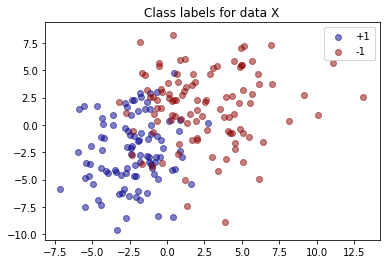

In [6]:
_, ax = plt.subplots()
ax.scatter(x[y == 1, 0], x[y == 1, 1], c="darkblue", label="+1", alpha=0.5)
ax.scatter(x[y != 1, 0], x[y != 1, 1], c="darkred", label="-1", alpha=0.5)
ax.legend()
ax.set_title("Class labels for data X")
plt.show()

The data look pretty already pretty separable on only two dimensions. Let's check if they are roughly balanced:

In [7]:
print("Number of +1 samples:", len(y[y==1]))
print("Number of -1 samples:", len(y[y!=1]))

Number of +1 samples: 96
Number of -1 samples: 104


Next we compute the matrix $Q$ that is a constant part of our loss function:

In [8]:
def Q(x, y):
    K = rbf_kernel(x, gamma=2)
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K[i, j] = K[i, j] * y[i] * y[j]            
    return K

q = Q(x, y)

This pretty much is all we need for optimization. We use `cvxpy`, since it's probably the easiest way to solve the loss function. As stated above there are more efficient algorithms available, but for the sake of the implementation this suffices.

First we declare the variable we want to optimize ($\alpha$). We need to specify its length, which is the number of samples:

In [9]:
alpha = Variable(N)

Then we specify the loss function:

In [10]:
loss = .5 * quad_form(alpha, q) -  sum_entries(alpha)

As a last step we formulate the problem, i.e. a minimization problem of the loss function. We also need to specify the constraints. Here I used $\alpha_i \le C$ with $C= 10$. Usually you would need to find this, for instance, with cross-validation.

In [11]:
prob = Problem(Minimize(loss),
             [alpha >= 0, alpha <= 10, alpha.T * y == 0])

Solve the problem:

In [12]:
solv = prob.solve()

That's it. We only need to retrieve the optimal estimates $\hat{\alpha}$:

In [13]:
alpha  = numpy.asarray(alpha.value).reshape(-1)

Finally let's benchmark our implementation vs `sklearn`. First we implement a function to predict a new label

In [14]:
def predict(x_new):
    x_new = x_new.reshape((1, x.shape[1]))
    ret = 0
    for i in range(x.shape[0]):
        ret += alpha[i] * y[i] * rbf_kernel(x[i, :].reshape((1, x.shape[1])), x_new)
    return numpy.sign(ret[0])

Then we predict $\hat{y}_{\text{new}}$ for our implementation and the `sklearn` SVM.

In [15]:
y_new_hat = numpy.array([predict(xt)[0] for xt in x_test])

In [16]:
y_svm_hat = svm.SVC(kernel="rbf", gamma=2).fit(x, y).predict(x_test)

As a last step we plot confusion matrices for the two predictors.

In [17]:
def plot_confusion_matrix(cm, classes, title):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = numpy.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

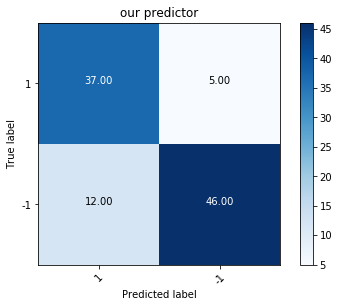

In [18]:
plot_confusion_matrix(confusion_matrix(y_test, y_new_hat), classes=["1", "-1"], title="our predictor")

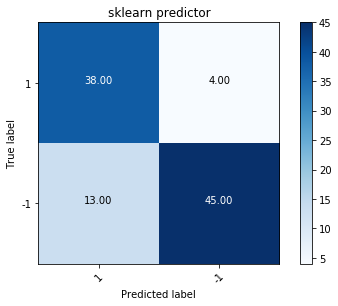

In [19]:
plot_confusion_matrix(confusion_matrix(y_test, y_svm_hat), classes=["1", "-1"], title="sklearn predictor")

Almost the same. :)